# Training a Transformer (CPU and GPU)

This notebook provides a detailed, from-scratch implementation of a Transformer model using **Nabla**. The primary goal is to demonstrate and compare Nabla's different execution modes.

**Learning Objectives:**
- Understand the core building blocks of the Transformer architecture.
- See how a complete sequence-to-sequence model is built and trained in Nabla.
- Compare the performance of three execution strategies:
  1. **Eager Mode**: Standard Python execution, great for debugging.
  2. **JIT on CPU**: Using Nabla's JIT compiler for a major speedup on the CPU.
  3. **JIT on Accelerator**: (Optional) Using the JIT compiler to automatically run on a GPU for maximum performance.

## 1. Imports and Configuration

First, we'll import the necessary libraries and define the core configuration parameters for our model and training task. These settings will be used across all execution modes.

In [1]:
# Installation and imports
import sys
from typing import Any, Callable

IN_COLAB = "google.colab" in sys.modules

try:
    import time

    import matplotlib.pyplot as plt
    import numpy as np

    import nabla as nb
except ImportError:
    import subprocess

    # Install required packages
    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "matplotlib",
            "numpy",
            "nabla-ml",
        ],
        check=True,
    )

    # Re-import after installation
    import time

    import matplotlib.pyplot as plt
    import numpy as np

    import nabla as nb

# ============================================================================
# CONFIGURATION
# ============================================================================

# Task Configuration
VOCAB_SIZE = 20  # Total vocabulary size (0=PAD, 1=START, 2=END, 3-19=content)
SOURCE_SEQ_LEN = 9  # Length of input sequences to reverse
TARGET_SEQ_LEN = SOURCE_SEQ_LEN + 2  # +1 for END token, +1 for START token in decoder
MAX_SEQ_LEN = TARGET_SEQ_LEN

# Model Architecture
NUM_LAYERS = 2  # Number of encoder and decoder layers
D_MODEL = 64  # Model dimension (embedding size)
NUM_HEADS = 4  # Number of attention heads (must divide D_MODEL)
D_FF = 128  # Feed-forward network hidden dimension

# Training Configuration
BATCH_SIZE = 512  # Number of sequences per training batch
LEARNING_RATE = 0.0005  # AdamW learning rate
NUM_EPOCHS = 300  # Total training epochs
PRINT_INTERVAL = 50  # Print progress every N epochs

## 2. Positional Encoding

Transformers process all tokens at once, so they don't inherently know their order. We add **Positional Encodings**—unique vectors based on a token's position—to give the model this crucial sequential context.

In [2]:
def positional_encoding(max_seq_len: int, d_model: int) -> nb.Tensor:
    """Create sinusoidal positional encodings for Nabla."""
    position = nb.ndarange((max_seq_len,)).reshape((max_seq_len, 1))
    half_d_model = d_model // 2
    dim_indices = nb.ndarange((half_d_model,)).reshape((1, half_d_model))
    scaling_factors = 10000.0 ** (2.0 * dim_indices / d_model)
    angles = position / scaling_factors
    sin_vals = nb.sin(angles)
    cos_vals = nb.cos(angles)
    stacked = nb.stack([sin_vals, cos_vals], axis=2)
    pe = stacked.reshape((max_seq_len, d_model))
    return pe.reshape((1, max_seq_len, d_model))

## 3. Scaled Dot-Product Attention

This is the heart of the Transformer. For a given token (the **Query**), it checks all other tokens in the sequence (the **Keys**) to see how relevant they are. It then creates a new representation for the token by taking a weighted average of all token representations (**Values**), based on these relevance scores.

In [3]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """Scaled dot-product attention for Nabla."""
    d_k = q.shape[-1]
    scores = nb.matmul(q, k.permute((0, 1, 3, 2))) / nb.sqrt(
        nb.tensor([d_k], dtype=nb.DType.float32)
    )
    if mask is not None:
        scores = nb.where(mask, scores, nb.full_like(scores, -1e9))
    attention_weights = nb.softmax(scores, axis=-1)
    output = nb.matmul(attention_weights, v)
    return output

## 4. Multi-Head Attention

Instead of calculating attention once, **Multi-Head Attention** does it multiple times in parallel in different "representation subspaces" (or **heads**). This allows the model to capture different types of relationships between tokens simultaneously, before combining all the results.

In [4]:
def multi_head_attention(x, xa, params, mask=None):
    """Multi-head attention for Nabla."""
    batch_size, seq_len, d_model = x.shape
    d_head = d_model // NUM_HEADS

    q_linear = nb.matmul(x, params["w_q"])
    k_linear = nb.matmul(xa, params["w_k"])
    v_linear = nb.matmul(xa, params["w_v"])

    q = q_linear.reshape((batch_size, seq_len, NUM_HEADS, d_head)).permute((0, 2, 1, 3))
    k = k_linear.reshape((batch_size, -1, NUM_HEADS, d_head)).permute((0, 2, 1, 3))
    v = v_linear.reshape((batch_size, -1, NUM_HEADS, d_head)).permute((0, 2, 1, 3))

    attention_output = scaled_dot_product_attention(q, k, v, mask)

    attention_output = attention_output.permute((0, 2, 1, 3)).reshape(
        (batch_size, seq_len, d_model)
    )
    return nb.matmul(attention_output, params["w_o"])

## 5. Position-wise Feed-Forward Network

After the attention mechanism, each token's representation is passed through a simple **Feed-Forward Network (FFN)**. This adds more learning capacity and is applied identically and independently to every position in the sequence.

In [5]:
def feed_forward(x, params):
    """Position-wise feed-forward network for Nabla."""
    hidden = nb.relu(nb.matmul(x, params["w1"]) + params["b1"])
    output = nb.matmul(hidden, params["w2"]) + params["b2"]
    return output

## 6. Layer Normalization

**Layer Normalization** is a technique used to stabilize and accelerate training. It works by rescaling the outputs of a layer to have a standard distribution. We apply it *before* each main operation (a common technique called **Pre-Norm**) to improve the flow of gradients.

In [6]:
def layer_norm(x, params, eps=1e-6):
    """Layer normalization for Nabla."""
    mean = nb.mean(x, axes=[-1], keep_dims=True)
    variance = nb.mean((x - mean) * (x - mean), axes=[-1], keep_dims=True)
    normalized = (x - mean) / nb.sqrt(variance + eps)
    return params["gamma"] * normalized + params["beta"]

## 7. Encoder and Decoder Layers

Now we assemble our building blocks into full layers. The **Encoder Layer** uses self-attention to process the input sequence. The **Decoder Layer** uses masked self-attention for the output sequence, and also uses cross-attention to look at the encoder's output, linking the input and output together.

In [7]:
def encoder_layer(x, params, mask):
    normed_x = layer_norm(x, params["norm1"])
    attention_output = multi_head_attention(
        normed_x, normed_x, params["mha"], mask
    )
    x = x + attention_output

    normed_x = layer_norm(x, params["norm2"])
    ffn_output = feed_forward(normed_x, params["ffn"])
    x = x + ffn_output
    return x


def decoder_layer(x, encoder_output, params, look_ahead_mask, padding_mask):
    normed_x = layer_norm(x, params["norm1"])
    masked_attention_output = multi_head_attention(
        normed_x, normed_x, params["masked_mha"], look_ahead_mask
    )
    x = x + masked_attention_output

    normed_x = layer_norm(x, params["norm2"])
    cross_attention_output = multi_head_attention(
        normed_x, encoder_output, params["cross_mha"], padding_mask
    )
    x = x + cross_attention_output

    normed_x = layer_norm(x, params["norm3"])
    ffn_output = feed_forward(normed_x, params["ffn"])
    x = x + ffn_output
    return x

## 8. Embedding Lookup

This helper function converts token IDs (integers) into dense vector representations (**embeddings**). We use a manual implementation here to showcase more of Nabla's API, though a direct, optimized lookup operation is typically used in practice.

In [8]:
def embedding_lookup(token_ids, embedding_matrix):
    """Manual embedding lookup for Nabla."""
    batch_size, seq_len = token_ids.shape
    vocab_size, d_model = embedding_matrix.shape
    output = nb.zeros((batch_size, seq_len, d_model))
    for token_idx in range(vocab_size):
        token_idx_tensor = nb.tensor([token_idx], dtype=nb.DType.int32)
        condition = nb.equal(
            token_ids, nb.broadcast_to(token_idx_tensor, token_ids.shape)
        )
        condition_expanded = nb.broadcast_to(
            condition.reshape((batch_size, seq_len, 1)), (batch_size, seq_len, d_model)
        )
        token_embedding = embedding_matrix[token_idx : token_idx + 1, :].reshape(
            (1, 1, d_model)
        )
        token_embedding_expanded = nb.broadcast_to(
            token_embedding, (batch_size, seq_len, d_model)
        )
        output = nb.where(condition_expanded, token_embedding_expanded, output)
    return output

## 9. Full Transformer Forward Pass

The **Full Forward Pass** ties everything together. It takes source and target sequences, adds embeddings and positional encodings, runs them through the stacks of encoder and decoder layers, and finally produces output logits for prediction.

In [9]:
def transformer_forward(encoder_inputs, decoder_inputs, params):
    target_seq_len = decoder_inputs.shape[1]
    positions = nb.ndarange((target_seq_len,))
    causal_mask = nb.greater_equal(
        nb.reshape(positions, (target_seq_len, 1)),
        nb.reshape(positions, (1, target_seq_len)),
    )
    look_ahead_mask = nb.reshape(causal_mask, (1, 1, target_seq_len, target_seq_len))

    encoder_seq_len = encoder_inputs.shape[1]
    decoder_seq_len = decoder_inputs.shape[1]

    encoder_embeddings = embedding_lookup(
        encoder_inputs, params["encoder"]["embedding"]
    )
    encoder_pos_enc = params["pos_encoding"][:, :encoder_seq_len, :]
    encoder_x = encoder_embeddings + encoder_pos_enc

    encoder_output = encoder_x
    for i in range(NUM_LAYERS):
        encoder_output = encoder_layer(
            encoder_output, params["encoder"][f"layer_{i}"], mask=None
        )
    encoder_output = layer_norm(encoder_output, params["encoder"]["final_norm"])

    decoder_embeddings = embedding_lookup(
        decoder_inputs, params["decoder"]["embedding"]
    )
    decoder_pos_enc = params["pos_encoding"][:, :decoder_seq_len, :]
    decoder_x = decoder_embeddings + decoder_pos_enc

    decoder_output = decoder_x
    for i in range(NUM_LAYERS):
        decoder_output = decoder_layer(
            decoder_output,
            encoder_output,
            params["decoder"][f"layer_{i}"],
            look_ahead_mask,
            padding_mask=None,
        )
    decoder_output = layer_norm(decoder_output, params["decoder"]["final_norm"])

    logits = nb.matmul(decoder_output, params["output_linear"])
    return logits

## 10. Loss Function

We use **Cross-Entropy Loss** to measure the difference between the model's predictions (logits) and the actual target sequence. This function tells us how 'wrong' the model is, allowing us to calculate gradients to correct it during backpropagation.

In [10]:
def manual_log_softmax(x, axis=-1):
    """Manual log softmax implementation for Nabla."""
    x_max = nb.max(x, axes=[axis], keep_dims=True)
    x_shifted = x - x_max
    log_sum_exp = nb.log(nb.sum(nb.exp(x_shifted), axes=[axis], keep_dims=True))
    return x_shifted - log_sum_exp


def cross_entropy_loss(logits, targets):
    """Cross-entropy loss for Nabla."""
    batch_size, seq_len = targets.shape
    vocab_size = logits.shape[-1]
    targets_expanded = targets.reshape((batch_size, seq_len, 1))
    vocab_indices = nb.ndarange((vocab_size,), dtype=nb.DType.int32).reshape(
        (1, 1, vocab_size)
    )
    one_hot_targets = nb.equal(targets_expanded, vocab_indices).astype(nb.DType.float32)
    log_probs = manual_log_softmax(logits)
    cross_entropy = -nb.sum(one_hot_targets * log_probs)
    return cross_entropy / batch_size

## 11. Parameter Initialization

This section defines functions to **initialize all the model's learnable parameters** (weights and biases) with sensible starting values. Proper initialization is crucial for stable and effective model training.

In [11]:
def _init_encoder_layer_params():
    return {
        "mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": nb.glorot_uniform((D_MODEL, D_FF)),
            "b1": nb.zeros((D_FF,)),
            "w2": nb.glorot_uniform((D_FF, D_MODEL)),
            "b2": nb.zeros((D_MODEL,)),
        },
        "norm1": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm2": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
    }


def _init_decoder_layer_params():
    return {
        "masked_mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "cross_mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": nb.glorot_uniform((D_MODEL, D_FF)),
            "b1": nb.zeros((D_FF,)),
            "w2": nb.glorot_uniform((D_FF, D_MODEL)),
            "b2": nb.zeros((D_MODEL,)),
        },
        "norm1": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm2": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm3": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
    }


def init_transformer_params():
    params: dict[str, Any] = {"encoder": {}, "decoder": {}}
    params["encoder"]["embedding"] = nb.randn((VOCAB_SIZE, D_MODEL))
    params["decoder"]["embedding"] = nb.randn((VOCAB_SIZE, D_MODEL))
    params["pos_encoding"] = positional_encoding(MAX_SEQ_LEN, D_MODEL)
    for i in range(NUM_LAYERS):
        params["encoder"][f"layer_{i}"] = _init_encoder_layer_params()
    params["encoder"]["final_norm"] = {
        "gamma": nb.ones((D_MODEL,)),
        "beta": nb.zeros((D_MODEL,)),
    }
    for i in range(NUM_LAYERS):
        params["decoder"][f"layer_{i}"] = _init_decoder_layer_params()
    params["decoder"]["final_norm"] = {
        "gamma": nb.ones((D_MODEL,)),
        "beta": nb.zeros((D_MODEL,)),
    }
    params["output_linear"] = nb.glorot_uniform((D_MODEL, VOCAB_SIZE))
    return params

## 12. Data Generation

This function **generates a batch of training data** for our sequence-reversal task. For each sample, it creates the encoder input, the 'teacher-forced' decoder input (which is the reversed sequence shifted right with a `<START>` token), and the final target sequence for the loss calculation.

In [12]:
def create_reverse_dataset(batch_size):
    """Generates a dataset batch for Nabla."""
    base_sequences_np = np.random.randint(
        3, VOCAB_SIZE, size=(batch_size, SOURCE_SEQ_LEN), dtype=np.int32
    )
    reversed_sequences_np = np.flip(base_sequences_np, axis=1)
    encoder_input_np = base_sequences_np
    start_tokens_np = np.ones((batch_size, 1), dtype=np.int32)  # <START> token (1)
    decoder_input_np = np.concatenate([start_tokens_np, reversed_sequences_np], axis=1)
    end_tokens_np = np.full((batch_size, 1), 2, dtype=np.int32)  # <END> token (2)
    target_np = np.concatenate([reversed_sequences_np, end_tokens_np], axis=1)
    return (
        nb.Tensor.from_numpy(encoder_input_np),
        nb.Tensor.from_numpy(decoder_input_np),
        nb.Tensor.from_numpy(target_np),
    )

## 13. Optimizer (AdamW)

We implement the **AdamW optimizer**, a standard and powerful algorithm for updating the model's parameters based on the computed gradients. It includes features like momentum and decoupled weight decay for efficient and stable learning.

In [13]:
def _init_adamw_state_recursive(params, m_states, v_states):
    for key, value in params.items():
        if isinstance(value, dict):
            m_states[key], v_states[key] = {}, {}
            _init_adamw_state_recursive(value, m_states[key], v_states[key])
        else:
            m_states[key] = nb.zeros_like(value)
            v_states[key] = nb.zeros_like(value)


def init_adamw_state(params):
    m_states, v_states = {}, {}
    _init_adamw_state_recursive(params, m_states, v_states)
    return m_states, v_states


def adamw_step(params, grads, m, v, step, lr):
    """A generic AdamW step for Nabla."""
    beta1, beta2, eps, weight_decay = 0.9, 0.999, 1e-8, 0.01
    max_grad_norm = 1.0

    total_grad_norm_sq = [0.0]

    def _calc_norm(g_dict):
        for g in g_dict.values():
            if isinstance(g, dict):
                _calc_norm(g)
            else:
                total_grad_norm_sq[0] += nb.sum(g * g)

    _calc_norm(grads)
    grad_norm = nb.sqrt(total_grad_norm_sq[0])
    clip_factor = nb.minimum(1.0, max_grad_norm / (grad_norm + 1e-8))

    updated_params, updated_m, updated_v = {}, {}, {}

    def _update(p_dict, g_dict, m_dict, v_dict, up_p, up_m, up_v):
        for key in p_dict:
            if isinstance(p_dict[key], dict):
                up_p[key], up_m[key], up_v[key] = {}, {}, {}
                _update(
                    p_dict[key],
                    g_dict[key],
                    m_dict[key],
                    v_dict[key],
                    up_p[key],
                    up_m[key],
                    up_v[key],
                )
            else:
                p, g, m_val, v_val = (
                    p_dict[key],
                    g_dict[key] * clip_factor,
                    m_dict[key],
                    v_dict[key],
                )
                up_m[key] = beta1 * m_val + (1.0 - beta1) * g
                up_v[key] = beta2 * v_val + (1.0 - beta2) * (g * g)
                m_corr = up_m[key] / (1.0 - beta1**step)
                v_corr = up_v[key] / (1.0 - beta2**step)
                up_p[key] = p - lr * (m_corr / (nb.sqrt(v_corr) + eps) + weight_decay * p)

    _update(params, grads, m, v, updated_params, updated_m, updated_v)
    return updated_params, updated_m, updated_v

## 14. Defining the Training Step & Inference

Here we define two key functions:
- **`_complete_training_step`**: This bundles one full training cycle: forward pass, loss calculation, and parameter update via the optimizer. We leave it undecorated for now.
- **`predict_sequence`**: This uses the trained model to generate an output sequence one token at a time (autoregressively).

In [14]:
def _complete_training_step(
    encoder_in, decoder_in, targets, params, m_states, v_states, step
):
    """The core, undecorated logic for a single training step."""

    def loss_fn(p):
        return cross_entropy_loss(transformer_forward(encoder_in, decoder_in, p), targets)

    loss_value, grads = nb.value_and_grad(loss_fn)(params)
    updated_params, updated_m, updated_v = adamw_step(
        params, grads, m_states, v_states, step, LEARNING_RATE
    )
    return updated_params, updated_m, updated_v, loss_value


def predict_sequence(encoder_input, params):
    """Autoregressive sequence prediction for Nabla."""
    if len(encoder_input.shape) == 1:
        encoder_input = encoder_input.reshape((1, encoder_input.shape[0]))

    decoder_tokens = [nb.ones((1,), dtype=nb.DType.int32)]

    for pos in range(1, TARGET_SEQ_LEN):
        current_decoder_input = nb.stack(decoder_tokens, axis=1)
        logits = transformer_forward(encoder_input, current_decoder_input, params)
        next_token_logits = logits[:, pos - 1, :]
        predicted_token = nb.argmax(next_token_logits, axes=-1).astype(nb.DType.int32)
        decoder_tokens.append(predicted_token)

    final_sequence = nb.stack(decoder_tokens, axis=1)
    return final_sequence[0]

## 15. Exploring Nabla's Execution Modes

Now we'll create our three different training functions to compare performance.

1.  **Eager Mode**: This is just the raw Python function. It is unoptimized and runs operations one by one, which is excellent for debugging.
2.  **JIT on CPU**: We use `nb.jit(auto_device=False)` to compile the function into an optimized kernel that runs specifically on the CPU (since we did not send any data to a GPU manually in the above code). Due to MAX's kernel fusion and other optimizations, this version runs significantly faster than eager mode.
3.  **JIT on Accelerator**: We use `nb.jit(auto_device=True)` (or just `nb.jit`). This compiles the function and also tells Nabla to automatically move the input data and parameters to the GPU before execution, yielding the best performance if an accelerator is available.

In [15]:
# Mode 1: Eager step (just an alias to the original function)
eager_training_step = _complete_training_step

# Mode 2: JIT-compiled step for CPU execution
jit_cpu_training_step = nb.jit(_complete_training_step, auto_device=False)

# Mode 3: (Optional) JIT-compiled step with automatic device placement
if nb.accelerator_count() > 0:
    # The 'auto_device=True' flag is the default, so we can just use nb.jit()
    # It automatically moves CPU tensors to the accelerator.
    jit_accelerator_training_step = nb.jit(_complete_training_step, auto_device=True)
    print(f"✅ Accelerator detected! '{nb.accelerator()}' will be used for the third run.")
else:
    jit_accelerator_training_step = None
    print("INFO: No accelerator detected. The accelerator-based training run will be skipped.")

✅ Accelerator detected! 'Device(type=gpu,id=0)' will be used for the third run.


## 16. Training and Benchmarking

We'll now **run the training process** for each of the defined modes. A generic `run_training_loop` function handles the process, allowing us to time each mode and collect its results for a fair comparison.

In [16]:
def run_training_loop(
    mode_name: str, training_step_fn: Callable[..., Any]
) -> dict[str, Any]:
    """Generic training loop to benchmark a given training step function."""
    print("=" * 60)
    print(f"🤖 TRAINING IN {mode_name.upper()} MODE")
    print("=" * 60)

    print("🔧 Initializing transformer parameters...")
    params = init_transformer_params()
    print("📈 Initializing AdamW optimizer...")
    m_states, v_states = init_adamw_state(params)

    # For JIT functions, the first few calls include compilation time.
    # We run a few 'warmup' steps to exclude this from our benchmark.
    print("🔥 Warming up (3 steps)...")
    for i in range(3):
        enc_in, dec_in, targets = create_reverse_dataset(BATCH_SIZE)
        params, m_states, v_states, _ = training_step_fn(
            enc_in, dec_in, targets, params, m_states, v_states, i + 1
        )
    print("✅ Warmup complete! Starting timed training...\n")

    start_time = time.time()
    loss_history = []
    time_history = [start_time]

    for epoch in range(1, NUM_EPOCHS + 1):
        enc_in, dec_in, targets = create_reverse_dataset(BATCH_SIZE)
        params, m_states, v_states, loss = training_step_fn(
            enc_in, dec_in, targets, params, m_states, v_states, epoch
        )
        loss_history.append(float(loss.to_numpy()))
        time_history.append(time.time())

        if epoch % PRINT_INTERVAL == 0:
            print(
                f"Epoch {epoch:5d} | Loss: {loss.to_numpy():.4f} | Time: {time_history[-1] - start_time:.1f}s"
            )

    total_time = time_history[-1] - start_time
    print(f"\n✅ {mode_name} Training complete! Total time: {total_time:.2f}s")

    return {
        "params": params,
        "loss_history": loss_history,
        "time_history": time_history,
        "total_time": total_time,
    }


# --- Run all training modes ---
results = {}

results["Eager"] = run_training_loop("Eager", eager_training_step)
results["JIT (CPU)"] = run_training_loop("JIT (CPU)", jit_cpu_training_step)

if jit_accelerator_training_step:
    results["JIT (Accelerator)"] = run_training_loop(
        "JIT (Accelerator)", jit_accelerator_training_step
    )

🤖 TRAINING IN EAGER MODE
🔧 Initializing transformer parameters...
📈 Initializing AdamW optimizer...
🔥 Warming up (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch    50 | Loss: 19.6114 | Time: 36.7s
Epoch   100 | Loss: 2.7368 | Time: 74.4s
Epoch   150 | Loss: 0.0540 | Time: 112.6s
Epoch   200 | Loss: 0.0172 | Time: 150.9s
Epoch   250 | Loss: 0.0109 | Time: 189.0s
Epoch   300 | Loss: 0.0080 | Time: 227.4s

✅ Eager Training complete! Total time: 227.39s
🤖 TRAINING IN JIT (CPU) MODE
🔧 Initializing transformer parameters...
📈 Initializing AdamW optimizer...
🔥 Warming up (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch    50 | Loss: 19.6109 | Time: 2.6s
Epoch   100 | Loss: 2.7349 | Time: 5.0s
Epoch   150 | Loss: 0.0537 | Time: 7.6s
Epoch   200 | Loss: 0.0178 | Time: 10.0s
Epoch   250 | Loss: 0.0100 | Time: 12.4s
Epoch   300 | Loss: 0.0085 | Time: 15.0s

✅ JIT (CPU) Training complete! Total time: 14.95s
🤖 TRAINING IN JIT (ACCELERATOR) MODE
🔧 Initializing tran

## 17. Performance Comparison

Let's visualize the performance. The 'Loss vs. Epochs' plot confirms all modes learn correctly. The **'Loss vs. Time' plot is key for seeing the speedup**. To make the comparison clear, we will zoom in on the timeframe of the JIT-compiled CPU run, as the Eager mode is significantly slower and would otherwise skew the graph.

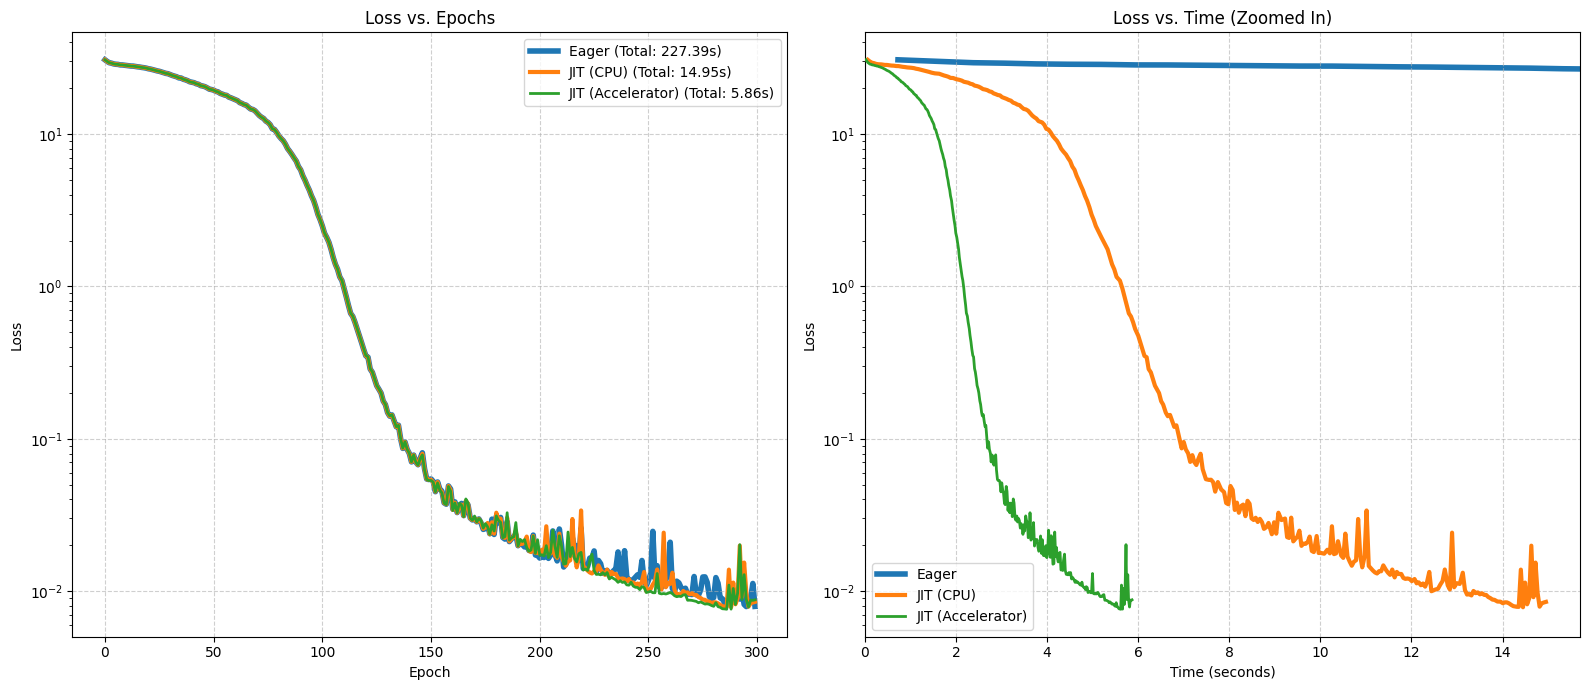

In [17]:
def plot_performance_comparison(results: dict[str, Any]):
    """Plot the loss curves for all completed training runs with varied line styles."""
    if not results:
        print("No results to plot.")
        return

    plt.figure(figsize=(16, 7))
    
    # Define styles to make overlapping lines visible
    linewidths = [4.0, 3.0, 2.0]
    zorders = [1, 2, 3]

    # Plot loss vs epochs
    plt.subplot(1, 2, 1)
    for i, (mode, data) in enumerate(results.items()):
        lw = linewidths[i] if i < len(linewidths) else 1.5
        z = zorders[i] if i < len(zorders) else 0
        
        plt.plot(
            data["loss_history"], 
            label=f'{mode} (Total: {data["total_time"]:.2f}s)', 
            linewidth=lw, 
            zorder=z
        )
        
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot loss vs time
    plt.subplot(1, 2, 2)
    for i, (mode, data) in enumerate(results.items()):
        lw = linewidths[i] if i < len(linewidths) else 1.5
        z = zorders[i] if i < len(zorders) else 0
        
        relative_times = [t - data["time_history"][0] for t in data["time_history"]]
        plt.plot(
            relative_times[1:], 
            data["loss_history"], 
            label=mode, 
            linewidth=lw, 
            zorder=z
        )

    if 'JIT (CPU)' in results:
        xlim_max = results['JIT (CPU)']['total_time'] * 1.05
        plt.xlim(0, xlim_max)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Loss")
    plt.title("Loss vs. Time (Zoomed In)")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_performance_comparison(results)

## 18. Final Evaluation

Finally, we take the parameters from the **fastest training run** and use them to make a few predictions on new, unseen data. This confirms that our model has successfully learned the sequence reversal task.

In [18]:
def evaluate_model(params):
    print("\n" + "=" * 60)
    print("🧪 FINAL NABLA EVALUATION")
    print("=" * 60)

    # Test on 5 random examples
    for i in range(5):
        test_enc_in, _, test_target = create_reverse_dataset(1)
        prediction = predict_sequence(test_enc_in[0], params)

        is_correct = np.array_equal(
            prediction[1:].to_numpy(), test_target[0].to_numpy()
        )
        print(f"Example {i + 1}:")
        print(f"  Input:           {test_enc_in[0].to_numpy()}")
        print(f"  Expected output: {test_target[0].to_numpy()}")
        print(f"  Predicted:       {prediction[1:].to_numpy()}")
        print(f"  Correct:         {'✅ YES' if is_correct else '❌ NO'}")


# Find the best parameters from the fastest run
if results:
    fastest_mode = min(results, key=lambda mode: results[mode]["total_time"])
    print(f"\nEvaluating model from the fastest run: '{fastest_mode}'")
    best_params = results[fastest_mode]['params']

    # Evaluate Nabla model
    evaluate_model(best_params)
else:
    print("\nSkipping evaluation as no training runs were completed.")


Evaluating model from the fastest run: 'JIT (Accelerator)'

🧪 FINAL NABLA EVALUATION


Example 1:
  Input:           [ 7 10  4 19  7 11  6  4  7]
  Expected output: [ 7  4  6 11  7 19  4 10  7  2]
  Predicted:       [ 7  4  6 11  7 19  4 10  7  2]
  Correct:         ✅ YES
Example 2:
  Input:           [18  5 19 17 13 19  3 18  6]
  Expected output: [ 6 18  3 19 13 17 19  5 18  2]
  Predicted:       [ 6 18  3 19 13 17 19  5 18  2]
  Correct:         ✅ YES
Example 3:
  Input:           [15 18  9 14 10  8  3  8 13]
  Expected output: [13  8  3  8 10 14  9 18 15  2]
  Predicted:       [13  8  3  8 10 14  9 18 15  2]
  Correct:         ✅ YES
Example 4:
  Input:           [15  3  5  6 18 14 17 16 17]
  Expected output: [17 16 17 14 18  6  5  3 15  2]
  Predicted:       [17 16 17 14 18  6  5  3 15  2]
  Correct:         ✅ YES
Example 5:
  Input:           [ 8 16  6 13 10  5  5 14  9]
  Expected output: [ 9 14  5  5 10 13  6 16  8  2]
  Predicted:       [ 9 14  5  5 10 13  6 16  8  2]
  Correct:         ✅ YES
